<a href="https://colab.research.google.com/github/woncoh1/era1a10/blob/main/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
- Data
    - Dataset: CIFAR-10
    - Data augmentation: Albumentations
- Model
    - Model architecture: ResNet
    - Loss function: Cross entropy
- Optimization
    - Optimization algorithm: Adam
    - LR scheduler: One-cycle policy

## Targets
- Test accuracy > 90.0 %
- Number of parameters: unlimited
- Number of epochs: 24

## Results
- Best train accuracy = 90.09 %
- Best test accuracy = 90.67 %
- Number of parameters = 6,573,120
- Number of epochs = 24

In [1]:
!git clone https://github.com/woncoh1/era1a10.git

Cloning into 'era1a10'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 75 (delta 34), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), 187.12 KiB | 2.34 MiB/s, done.


In [2]:
%pip install torchinfo -Uqq
%pip install albumentations -Uqq
%pip install torch-lr-finder -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.2 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchinfo import summary
from torch_lr_finder import LRFinder

from era1a10.src import data, engine, models, utils

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Device

## Colab runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch device
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

In [5]:
params_dataloader = {
    'batch_size': 512,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [6]:
transform = data.get_transform()
dataset = data.get_dataset(transform)
loader = data.get_dataloader(dataset, params_dataloader)

100%|██████████| 170498071/170498071 [00:06<00:00, 27979516.55it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


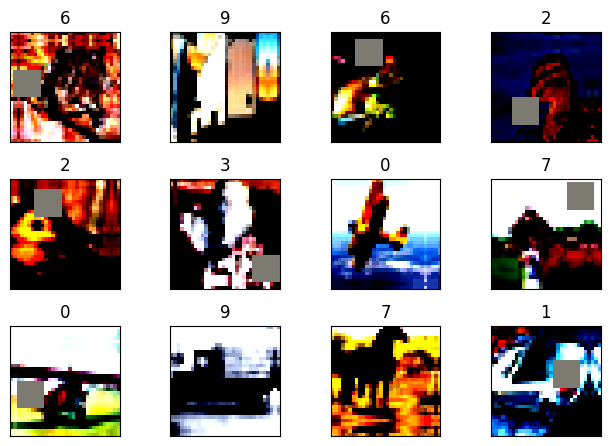

In [7]:
utils.plot_batch_samples(loader['train'])

# Model

In [8]:
criterion = nn.CrossEntropyLoss()
model = models.PageNet().to(device)

summary(
    model,
    input_size=(params_dataloader['batch_size'], *data.CHW),
    row_settings=['var_names'],
)

Layer (type (var_name))                  Output Shape              Param #
PageNet (PageNet)                        [512, 10]                 --
├─Sequential (conv0)                     [512, 64, 32, 32]         --
│    └─Conv2d (0)                        [512, 64, 32, 32]         1,728
│    └─BatchNorm2d (1)                   [512, 64, 32, 32]         128
│    └─Dropout (2)                       [512, 64, 32, 32]         --
│    └─ReLU (3)                          [512, 64, 32, 32]         --
├─SkipBlock (conv1)                      [512, 128, 16, 16]        --
│    └─Sequential (conv)                 [512, 128, 16, 16]        --
│    │    └─Conv2d (0)                   [512, 128, 32, 32]        73,728
│    │    └─MaxPool2d (1)                [512, 128, 16, 16]        --
│    │    └─BatchNorm2d (2)              [512, 128, 16, 16]        256
│    │    └─Dropout (3)                  [512, 128, 16, 16]        --
│    │    └─ReLU (4)                     [512, 128, 16, 16]        --
│    └

# Training

## Find max LR

In [9]:
params_optimizer = {
    'lr': 0.03,
    'weight_decay': 1E-4,
}
params_lr_finder = {
    'end_lr': 10,
    'num_iter': 200,
    'step_mode': 'exp',
}

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.79E-02


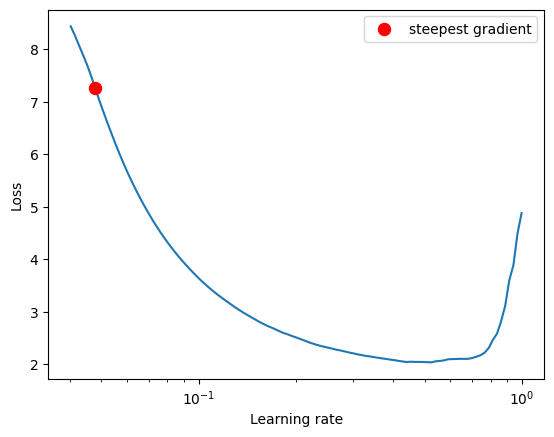

In [10]:
optimizer = optim.Adam(model.parameters(), **params_optimizer)
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(loader['train'], **params_lr_finder)
lr_finder.plot() # Inspect the loss-learning rate graph
lr_finder.reset() # Reset the model and optimizer to their initial states

## Update weights

In [11]:
params_trainer = {
    'num_epochs': 24,
}
params_scheduler = {
    'max_lr': 5.0E-02, # From lr_finder
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
    'pct_start': 0.2, # 20 % warm-up phase
    'anneal_strategy': 'linear', # Linear cool-down phase
    'three_phase': False, # No annihilation phase
    'div_factor': 100, # Initial LR: start from 1 % of max_lr
}

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00289, Accuracy = 47.79%, Epoch = 1
Test : Loss = 0.00338, Accuracy = 46.03%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00214, Accuracy = 62.01%, Epoch = 2
Test : Loss = 0.00264, Accuracy = 58.08%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00175, Accuracy = 69.40%, Epoch = 3
Test : Loss = 0.00230, Accuracy = 60.20%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00154, Accuracy = 72.63%, Epoch = 4
Test : Loss = 0.00206, Accuracy = 65.93%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00152, Accuracy = 73.16%, Epoch = 5
Test : Loss = 0.00206, Accuracy = 64.77%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00150, Accuracy = 73.36%, Epoch = 6
Test : Loss = 0.00166, Accuracy = 71.24%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00144, Accuracy = 74.57%, Epoch = 7
Test : Loss = 0.00210, Accuracy = 65.57%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00143, Accuracy = 74.91%, Epoch = 8
Test : Loss = 0.00182, Accuracy = 69.45%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00139, Accuracy = 75.40%, Epoch = 9
Test : Loss = 0.00149, Accuracy = 74.67%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00136, Accuracy = 75.81%, Epoch = 10
Test : Loss = 0.00147, Accuracy = 74.52%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00134, Accuracy = 76.57%, Epoch = 11
Test : Loss = 0.00186, Accuracy = 68.96%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00132, Accuracy = 76.61%, Epoch = 12
Test : Loss = 0.00178, Accuracy = 69.65%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00128, Accuracy = 77.59%, Epoch = 13
Test : Loss = 0.00131, Accuracy = 77.27%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00124, Accuracy = 78.31%, Epoch = 14
Test : Loss = 0.00133, Accuracy = 77.05%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00122, Accuracy = 78.45%, Epoch = 15
Test : Loss = 0.00133, Accuracy = 76.94%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00119, Accuracy = 79.00%, Epoch = 16
Test : Loss = 0.00179, Accuracy = 69.85%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00113, Accuracy = 80.10%, Epoch = 17
Test : Loss = 0.00124, Accuracy = 78.80%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00108, Accuracy = 81.05%, Epoch = 18
Test : Loss = 0.00116, Accuracy = 80.47%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00104, Accuracy = 81.66%, Epoch = 19
Test : Loss = 0.00119, Accuracy = 79.55%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00098, Accuracy = 82.72%, Epoch = 20
Test : Loss = 0.00100, Accuracy = 82.73%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00089, Accuracy = 84.23%, Epoch = 21
Test : Loss = 0.00084, Accuracy = 85.20%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00079, Accuracy = 85.91%, Epoch = 22
Test : Loss = 0.00086, Accuracy = 84.97%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00068, Accuracy = 87.84%, Epoch = 23
Test : Loss = 0.00063, Accuracy = 89.51%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00056, Accuracy = 90.09%, Epoch = 24
Test : Loss = 0.00056, Accuracy = 90.67%



# Evaluation

## Learning curves

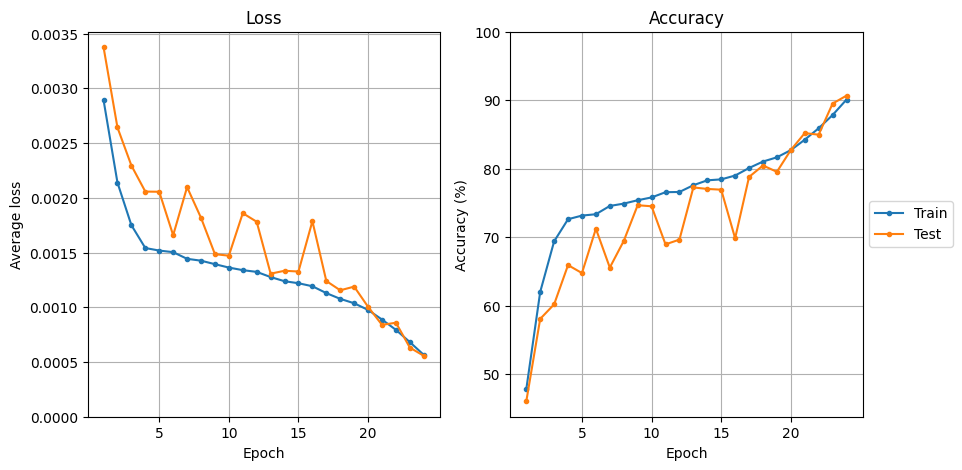

In [12]:
utils.plot_learning_curves(results, params_trainer['num_epochs'])

## Incorrect predictions

In [13]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, params_dataloader)['test'],
    model,
    criterion
)

Total Incorrect Predictions 933


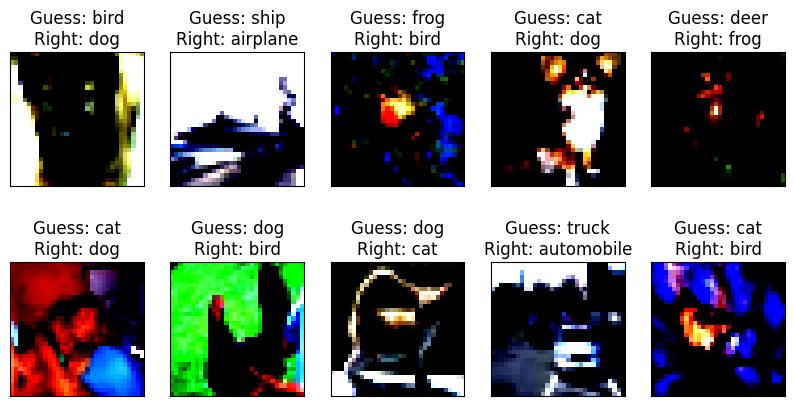

In [14]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)